# Exploratory Analysis of Olist dataset

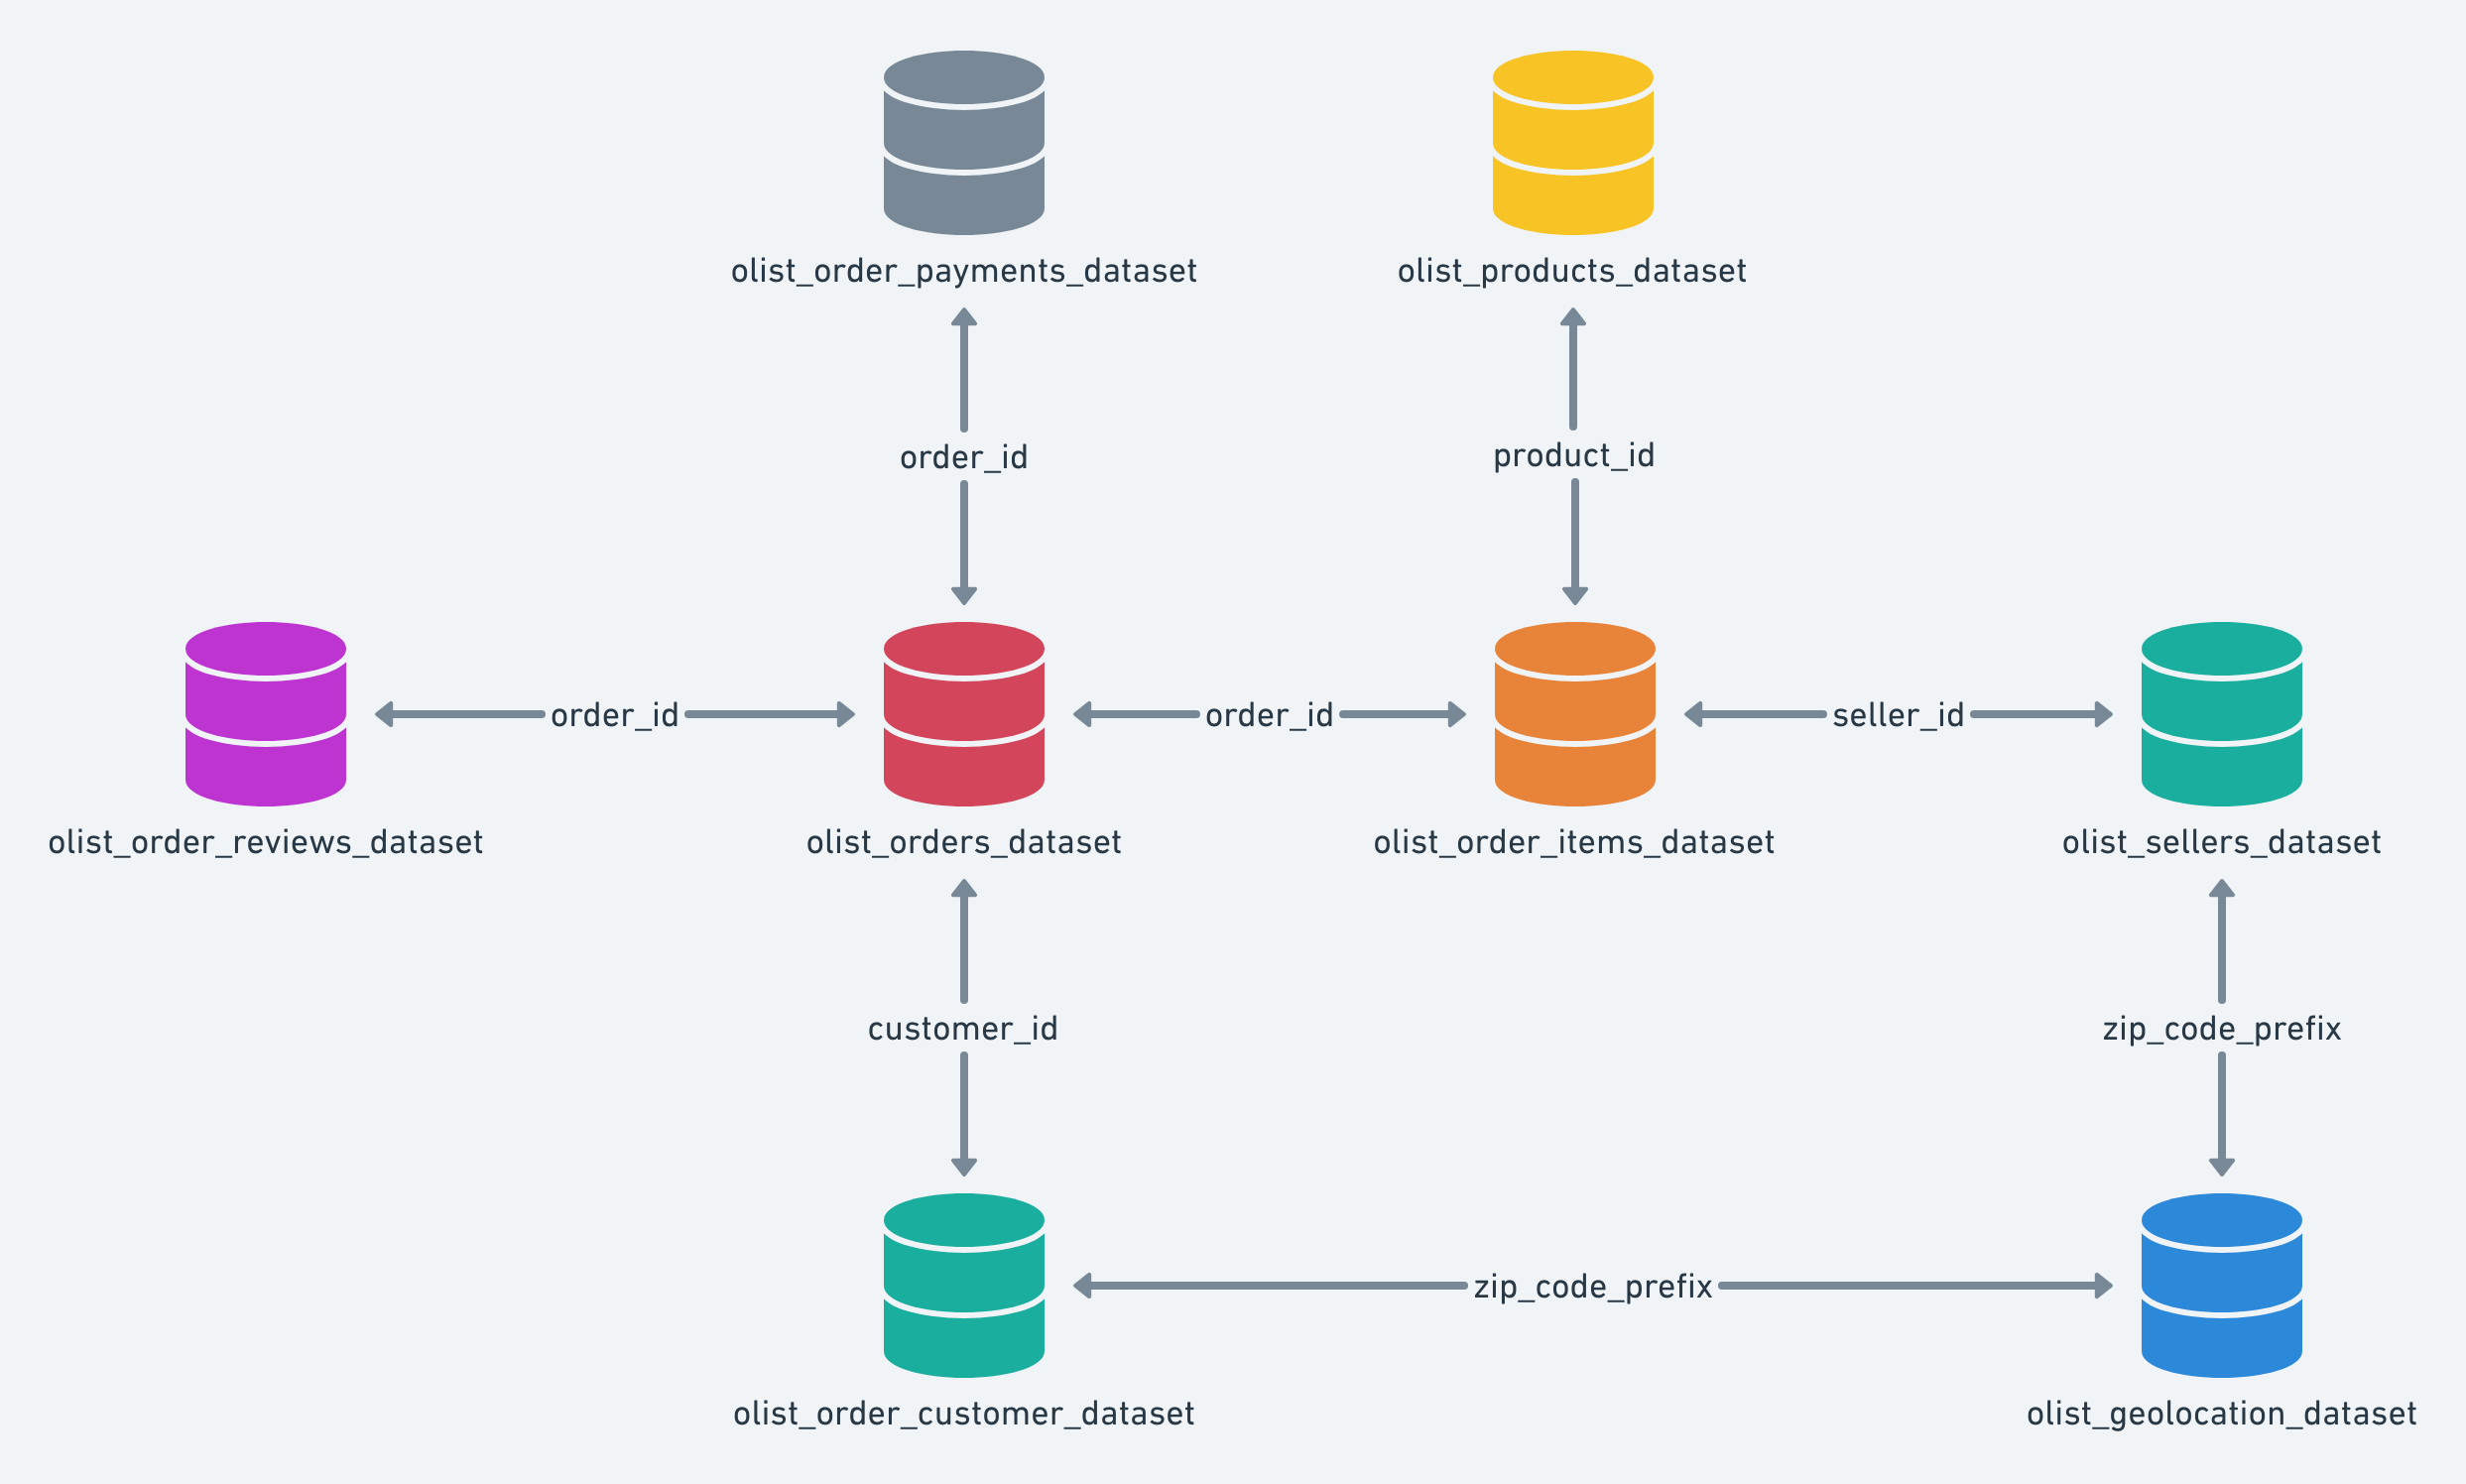

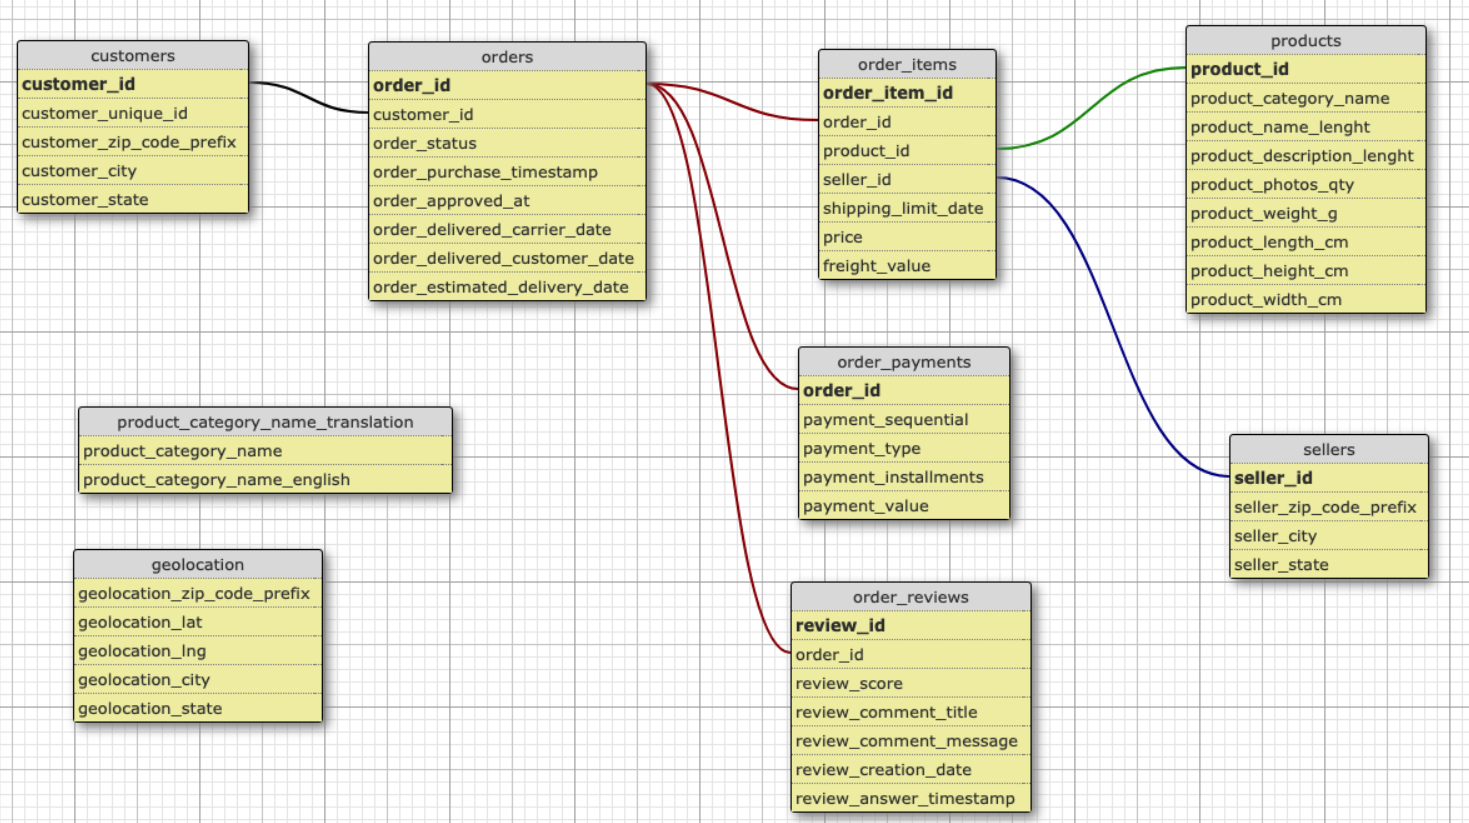

In [206]:
# import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

from olistpackage.data import Olist

In [1]:
# magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Instantiate the Olist class 
# which main purpose is downloading Olist csv files.
olist = Olist()

In [3]:
# Download Olist csv files in root/data/csv folder.
# If all the csv files exists already, do nothing.
# Uses the Kaggle Official API for donwloading Olist csv files.
# Kaggle Official API credentials are asked by opendatasets.download().
# Sign in to https://kaggle.com/, then click on your profile picture
# on the top right and select "My Account" from the menu.
# Scroll down to the "API" section and click "Create New API Token".
# This will download a file kaggle.json with the following contents:
# {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}

olist.download_data()

The Olist csv files are already downloaded.


In [8]:
# get the Olist csv files data into a dictionary of dataframes
data = olist.get_data()

Each transaction on the Olist ecommerce platform is characterized by:
- a `customer_id`, that would buy...
- various`product_id`...
- to a `seller_id`...
- and leaves a `rewiew_id`...
- all this belonging to an `order_id`

## 1 - Run an automated exploratory analysis with [SweetViz](https://pypi.org/project/sweetviz/)

The reports are stored in the project-root/data/reports directory

In [5]:
datasets_to_profile = ['orders', 'products', 'sellers',
                  'customers', 'order_reviews',
                  'order_items']

In [6]:
for d in datasets_to_profile:
    print('exporting: '+d)
    path = os.path.join("..", "data", "reports", d+".html")
    analyze_report = sv.analyze(data['orders'])
    analyze_report.show_html(path, open_browser=False)

exporting: orders


                                             | | [  0%]   00:00 -> 

Report ../data/reports/orders.html was generated.
exporting: products


                                             | | [  0%]   00:00 -> 

Report ../data/reports/products.html was generated.
exporting: sellers


                                             | | [  0%]   00:00 -> 

Report ../data/reports/sellers.html was generated.
exporting: customers


                                             | | [  0%]   00:00 -> 

Report ../data/reports/customers.html was generated.
exporting: order_reviews


                                             | | [  0%]   00:00 -> 

Report ../data/reports/order_reviews.html was generated.
exporting: order_items


                                             | | [  0%]   00:00 -> 

Report ../data/reports/order_items.html was generated.


## 2 - Investigate the cardinalities of the various DataFrames

### 2.1 - Nunique, count and ratio

In [7]:
index_label = [
    'orders',
    'products',
    'sellers',
    'customers',
    'order_reviews',
    'order_items',
    'order_items',
    'products'
]

data_count = pd.Series([
data['orders'].order_id.count(),
data['products'].product_id.count(),
data['sellers'].seller_id.count(),
data['customers'].customer_id.count(),
data['order_reviews'].order_id.count(),
data['order_items'].order_id.count(),
data['order_items'].product_id.count(),
data['products'].product_id.count()
], dtype=int, index=index_label)

data_nunique = pd.Series([
data['orders'].order_id.nunique(),
data['products'].product_id.nunique(),
data['sellers'].seller_id.nunique(),
data['customers'].customer_id.nunique(),
data['order_reviews'].review_id.nunique(),
data['order_items'].order_id.nunique(),
data['order_items'].product_id.nunique(),
data['products'].product_id.nunique()
], dtype=int, index=index_label)

ratio = (data_nunique / data_count).round(2)

cardinalities = pd.concat([data_nunique, data_count, ratio], axis=1).convert_dtypes().transpose()
cardinalities.rename(index={0: 'nunique', 1: 'count', 2: 'ratio'}, inplace=True)

cardinalities

,orders,products,sellers,customers,order_reviews,order_items,order_items,products
nunique,99441,32951,3095,99441,98410,98666,32951,32951
count,99441,32951,3095,99441,99224,112650,112650,32951
ratio,1.0,1.0,1.0,1.0,0.99,0.88,0.29,1.0


### 2.2 - Number of reviews per order

In [8]:
merged_tables = data['orders'].merge(data['order_reviews'], on='order_id', how='outer')
number_of_reviews = merged_tables[['order_id', 'review_id']].groupby(by='order_id').count().rename(columns={'review_id': 'Number_of_reviews'})
number_of_reviews.head()

,Number_of_reviews
order_id,
00010242fe8c5a6d1ba2dd792cb16214,1
00018f77f2f0320c557190d7a144bdd3,1
000229ec398224ef6ca0657da4fc703e,1
00024acbcdf0a6daa1e931b038114c75,1
00042b26cf59d7ce69dfabb4e55b4fd9,1


In [9]:
number_of_reviews.agg([min, max])

,Number_of_reviews
min,0
max,3


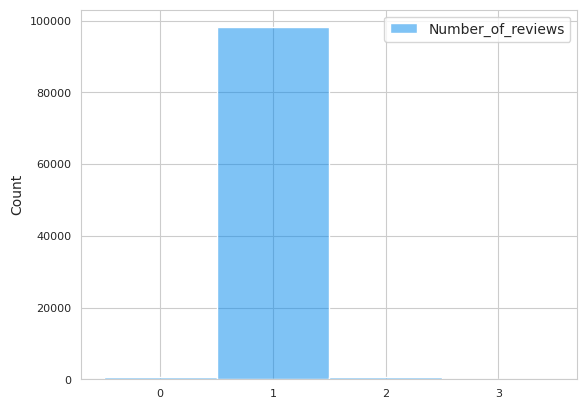

In [10]:
sns.set_style("whitegrid")
sns.histplot(number_of_reviews, discrete=True).set_xticks(range(0,4));

In [11]:
# Check missing reviews
merged_tables[['review_id']].isna().sum()

review_id    768
dtype: int64

Nearly all orders have a review, except 768 out of 100000 (less than 0.7% missing)

## 3 - Metric Design

### 3.1 Orders vs. reviews

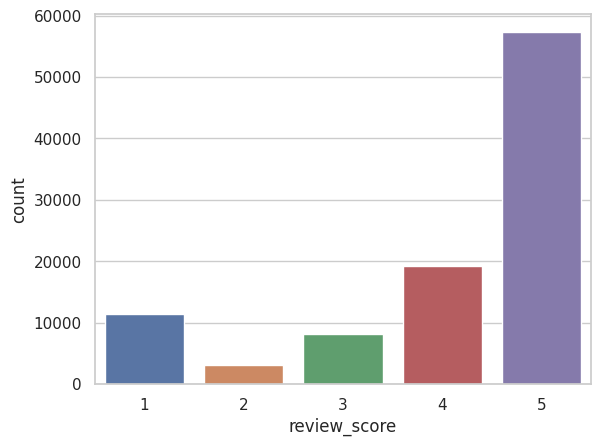

In [14]:
# histogram of review_score
sns.set_style("whitegrid")
sns.countplot(data=data['order_reviews'], x='review_score');

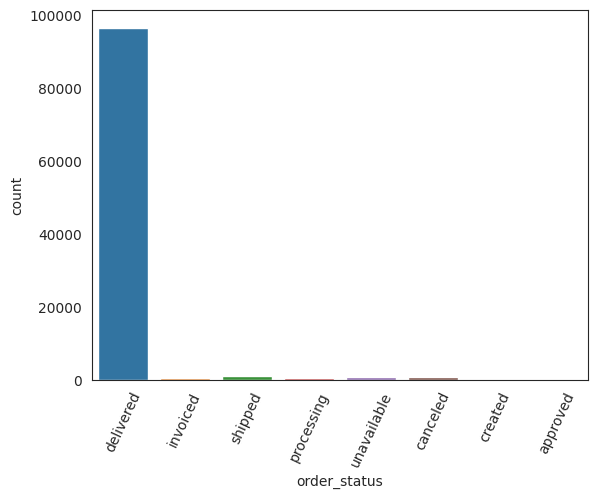

In [9]:
# histogram of order_status
g = sns.countplot(data=data['orders'], x="order_status")
g.set_xticklabels(g.get_xticklabels(), rotation=65, horizontalalignment='center');

In [84]:
# cardinalities of order_status
df = data['orders']['order_status'].value_counts().reset_index()
df.columns=["order_status", "total"]

df

,order_status,total
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


In [11]:
# The data schema shows that each `review` has a unique `order`.
# Check the number of order without review score
merged_df = data['orders'].merge(data['order_reviews'], on='order_id', how='left')
n_order_without_review = merged_df['review_score'].isna().sum()

n_order_without_review 

768

In [19]:
# Check the order status of orders without review score
# review_score != review_score returns True if review_score is NaN
merged_df.query("review_score != review_score").groupby(by="order_status").count()["order_id"] \
    .sort_values(ascending=False).reset_index().rename(columns={"order_id": "total"})

,order_status,total
0,delivered,646
1,shipped,75
2,canceled,20
3,unavailable,14
4,processing,6
5,invoiced,5
6,created,2


### 3.2 Evolution of key business metrics

Let's plot a trend line for the following metrics:
- order numbers
- customer satisfaction
- shipping delay

#### 3.2.1 Order numbers

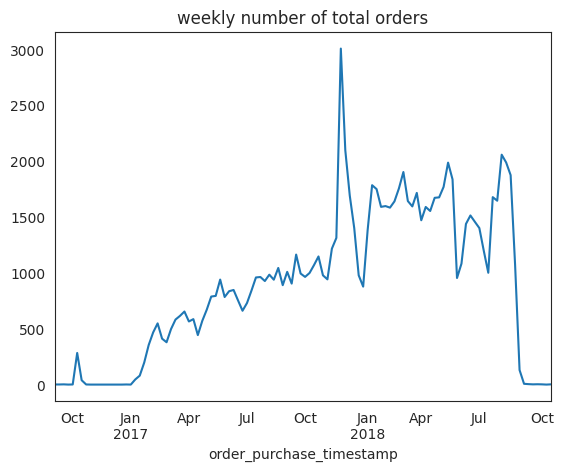

In [64]:
# Orders dataset
orders = data['orders'].copy()

# Convert timestamp into datetime object, set it as index,
# resample on a weekly base and count the number of orders for each week
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders = orders.set_index('order_purchase_timestamp').sort_index() \
    
# plot the weekly number of total orders
orders['order_id'].resample(rule="W").count().plot().set_title("weekly number of total orders");

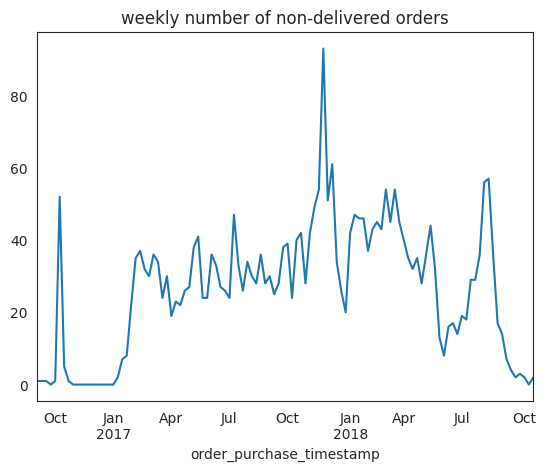

In [65]:
# plot the weekly number of non-delivered orders
orders.query("order_status!='delivered'")['order_id'].resample(rule="W").count() \
    .plot().set_title("weekly number of non-delivered orders");

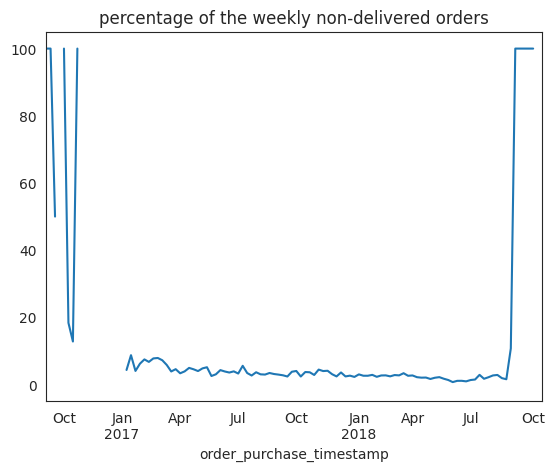

In [66]:
# compute the pourcentage of the weekly non-delivered orders
percentage = (orders.query("order_status!='delivered'")['order_id'].resample(rule="W").count() 
    / orders['order_id'].resample(rule="W").count())
# plot that pourcentage
(percentage*100).plot().set_title("percentage of the weekly non-delivered orders");
#orders['order_id'].resample(rule="W").count().plot()

#### 3.2.2 Weekly total payment values

In [76]:
# compute the total payment for each order_id
total_payments = data['order_payments'].groupby(by="order_id").sum()["payment_value"] \
    .reset_index().rename(columns={"payment_value": "total_payment"})

# merge total_payments with orders
merged_df = data['orders'].merge(total_payments, on="order_id")

# Convert timestamps into datetime object
for col in ['order_purchase_timestamp', 'order_approved_at', \
            'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']: 
    merged_df[col] = pd.to_datetime(merged_df[col])
    
# set order_purchase_timestamp as index, resample on a weekly base
# this weekly_df will be used for the next two plots
weekly_df = merged_df.set_index("order_purchase_timestamp").resample("W")

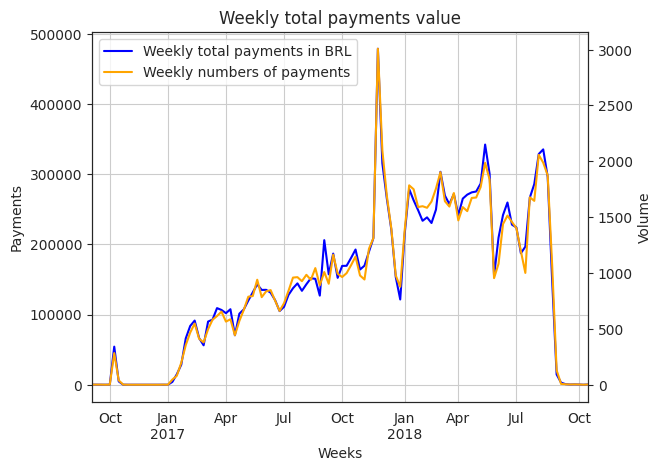

In [68]:
# plot weekly payments and weekly number of payments

# seaborn style
sns.set_style("white")

# getting axes, duplicating the ax1
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# Weekly payments and Mean Payments
weekly_df.sum()['total_payment'].plot(ax=ax1, label="Weekly total payments in BRL", color="blue")
weekly_df.count()["order_id"].plot(ax=ax2, label="Weekly numbers of payments", color="orange")

# x and y labels
ax1.set_xlabel("Weeks")
ax1.set_ylabel("Payments")
ax2.set_ylabel("Volume")

# title
plt.title("Weekly total payments value")

# common legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# grid
ax1.grid()

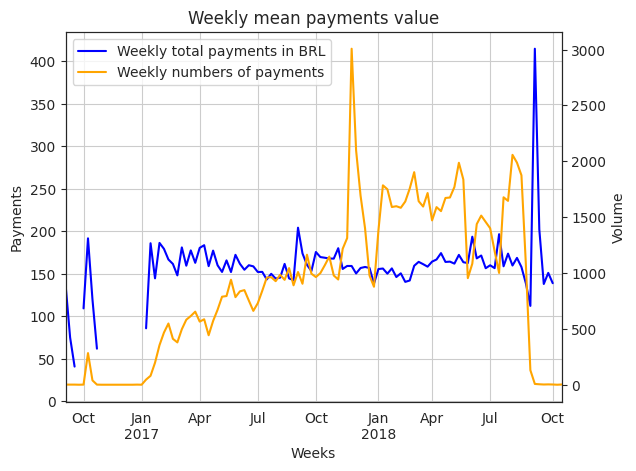

In [140]:
# plot weekly mean payments and weekly number of payments

# getting axes, duplicating the ax1
ax1 = plt.gca()
ax2 = ax1.twinx()

# Weekly payments and Mean Payments
weekly_df.mean()['total_payment'].plot(ax=ax1, label="Weekly total payments in BRL", color="blue")
weekly_df.count()["order_id"].plot(ax=ax2, label="Weekly numbers of payments", color="orange")

# x and y labels
ax1.set_xlabel("Weeks")
ax1.set_ylabel("Payments")
ax2.set_ylabel("Volume")

# title
plt.title('Weekly mean payments value')

# common legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# grid
ax1.grid();

#### 3.2.3 Customer Satisfaction

In [70]:
# reviews dataset
reviews = data['order_reviews'].copy()

# Convert timestamp into datetime object
for col in ['review_creation_date', 'review_answer_timestamp']: 
    reviews[col] = pd.to_datetime(reviews[col])
    
# set order_purchase_timestamp as index, resample on a weekly base
weekly_df2 = reviews.set_index("review_creation_date").resample("M")

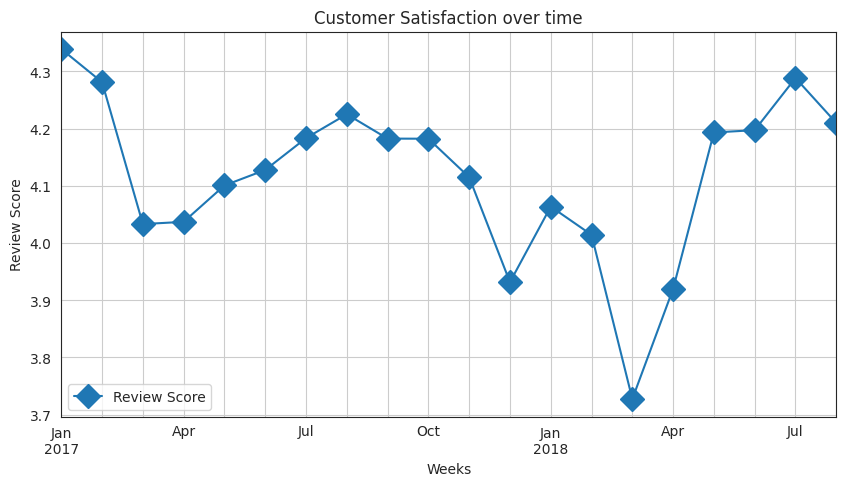

In [71]:
# size and getting axe
plt.figure(figsize=(10,5))
ax = plt.gca()

# plot customer satsifaction overtime
weekly_df2.mean()["review_score"].loc['2017-01-01':] \
    .plot(ax=ax, marker = "D", markersize = 12, label="Review Score")

# x and y labels
ax.set_xlabel("Weeks")
ax.set_ylabel("Review Score")

# title
ax.set_title("Customer Satisfaction over time")

# common legend
ax.legend(loc="lower left")

# grid
ax.grid(which="both");

#### 3.2.4 Shipping delay

In [117]:
# copy of orders dataframe
orders_shipping_delay = data['orders'].copy()

# convert date and timestamp into datetime type
for col in [
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_purchase_timestamp']:
    orders_shipping_delay[col] = pd.to_datetime(orders_shipping_delay[col])

# delay between the actual delivery and the estimated delivery date
orders_shipping_delay['delay_vs_expected'] = \
    (orders_shipping_delay['order_delivered_customer_date'] \
    - orders_shipping_delay['order_estimated_delivery_date']) \
    / np.timedelta64(24, 'h')

# delay between the actual delivery and the order purchase date
orders_shipping_delay['wait_time'] = \
    (orders_shipping_delay['order_delivered_customer_date'] \
    - orders_shipping_delay['order_purchase_timestamp']) \
    / np.timedelta64(24, 'h')

# True if the delivery was with delay, else False
orders_shipping_delay['was_late'] = orders_shipping_delay['delay_vs_expected'].apply(lambda x: x>0)

In [118]:
round(orders["was_late"].value_counts(normalize=True), 2)

False    0.92
True     0.08
Name: was_late, dtype: float64

- 92% of the orders are delivered on time
- 8% of the orders are delivered after the estimated time of delivery

In [146]:
# agregate orders_shipping_delay dataframe per week
delay_per_week = orders_shipping_delay.set_index("order_purchase_timestamp") \
    .resample("W").agg({
    "wait_time": np.mean,
    "delay_vs_expected": np.mean,
    "was_late": sum,
    "order_id": "count"})
delay_per_week.columns = [
    "avg_wait_time",
    "avg_delay_vs_expected",
    "nb_of_delays",
    "nb_of_orders"]

# compute the percentage of orders delivered lately each week
delay_per_week['percentage_of_lateness'] = \
    round(delay_per_week['nb_of_delays'] / delay_per_week['nb_of_orders'], 2)


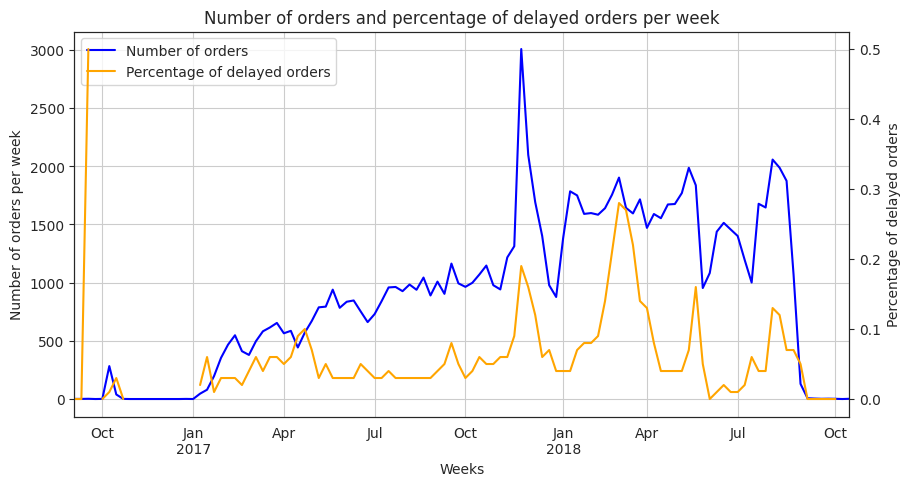

In [149]:
# Plot of the percentage of delayed orders per week

with plt.style.context('seaborn-deep'):
    # figure size, getting axes and duplicating the ax1
    plt.figure(figsize=(10,5))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # number of orders and percentage of delayed orders
    delay_per_week['nb_of_orders'].plot(ax=ax1, label="Number of orders", color="blue")
    delay_per_week['percentage_of_lateness'].plot(ax=ax2, label="Percentage of delayed orders", color="orange")

    # x and y labels
    ax1.set_xlabel("Weeks")
    ax1.set_ylabel("Number of orders per week")
    ax2.set_ylabel("Percentage of delayed orders")

    # title
    plt.title('Number of orders and percentage of delayed orders per week')

    # common legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # grid
    ax1.grid();

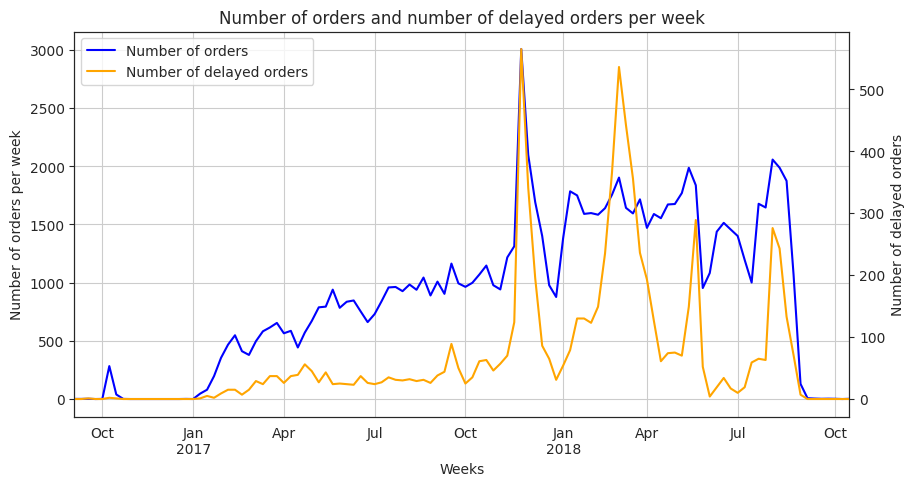

In [150]:
# Plot of the number of delayed orders per week

with plt.style.context('seaborn-deep'):
    # figure size, getting axes and duplicating the ax1
    plt.figure(figsize=(10,5))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # number of delayed orders and number of orders
    delay_per_week['nb_of_orders'].plot(ax=ax1, label="Number of orders", color="blue")
    delay_per_week['nb_of_delays'].plot(ax=ax2, label="Number of delayed orders", color="orange")

    # x and y labels
    ax1.set_xlabel("Weeks")
    ax1.set_ylabel("Number of orders per week")
    ax2.set_ylabel("Number of delayed orders")

    # title
    plt.title('Number of orders and number of delayed orders per week')

    # common legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # grid
    ax1.grid();

From the previous graphs, Olist experienced major lateness issues during several periods.   
Let's compute the number of weeks for which the orders were delivered later than expected.

In [202]:
# dataframe for lateness computings
lateness_df = delay_per_week[['nb_of_delays', 'nb_of_orders','percentage_of_lateness']] \
    .sort_values(by = 'percentage_of_lateness', ascending = False)

# delayed orders per week: 20% and more
lateness_20_and_more = lateness_df.query("percentage_of_lateness>=0.20")

# delayed orders per week: 15-20%
lateness_15_20 = lateness_df.query("0.15<=percentage_of_lateness<0.20")

# delayed orders per week: 10-15%
lateness_10_15 = lateness_df.query("0.10<=percentage_of_lateness<0.15")

# delayed orders per week: 5-10%
lateness_05_10 = lateness_df.query("0.05<=percentage_of_lateness<0.10")

# delayed orders per week: 5% and less
lateness_05_and_less = lateness_df.query("percentage_of_lateness<0.05")

# separates these weeks into subgroups
lateness_df = pd.DataFrame.from_dict({
" ≥ 20%": [len(lateness_20_and_more)],
"15% - 20%": [len(lateness_15_20)],
"10% - 15%": [len(lateness_10_15)],
"5% - 10%": [len(lateness_05_10)],
" ≤ 5%": [len(lateness_05_and_less)]  
}).T.reset_index()
lateness_df.columns = ['brackets', 'nb_weeks']

lateness_df

,brackets,nb_weeks
0,≥ 20%,5
1,15% - 20%,3
2,10% - 15%,7
3,5% - 10%,32
4,≤ 5%,54


In [201]:
sum(lateness_df['nb_weeks'])

101

Among these 101 weeks, Olist encountered serious troubles:
* there are 5 weeks for which more than 20% of the orders were delivered way later than expected
* there are 3 weeks for which more 15-20% of the orders were delivered way later than expected
* there are 7 weeks for which more 10-15% of the orders were delivered way later than expected

In [ ]:
# Revoir conclusion